In [ ]:
!git clone https://github.com/akhileshm0507/Double-Slit-Simulation.git
%cd Double-Slit-Simulation


Cloning into 'Double-Slit-Simulation'...
Username for 'https://github.com': 

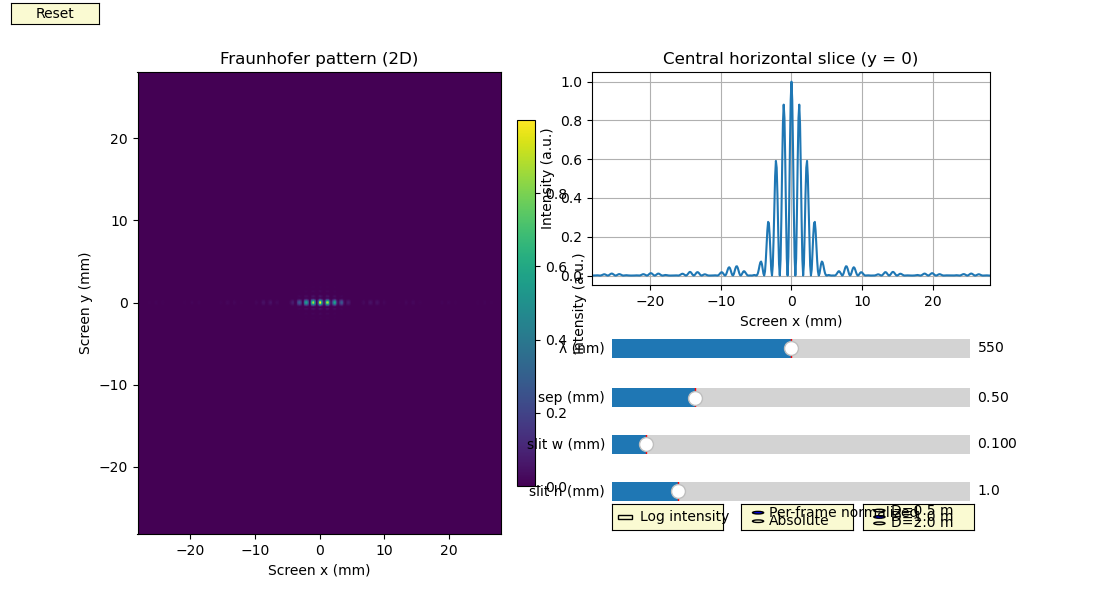

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
import matplotlib.gridspec as gridspec

# ------------------------
# Helper functions
# ------------------------
def make_aperture(N, L, slit_width, slit_height, separation):
    """
    Create a binary double-slit aperture mask.

    Parameters
    ----------
    N : int
        Grid size (NxN).
    L : float
        Side length of the aperture plane (meters).
    slit_width : float
        Slit width (meters).
    slit_height : float
        Slit height (meters).
    separation : float
        Center-to-center separation between slits (meters).

    Returns
    -------
    aperture : (N,N) ndarray
        Binary (0/1) aperture mask.
    x, y : ndarray
        Coordinates arrays (meters) for aperture plane (1D).
    dx : float
        Grid spacing (meters).
    """
    dx = L / N
    # use centered grid: from -L/2 to +L/2 (exclusive end handled by linspace with endpoint=False)
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    y = np.linspace(-L/2, L/2, N, endpoint=False)
    X, Y = np.meshgrid(x, y)
    aperture = np.zeros((N, N), dtype=float)

    # masks for two rectangular slits (centered at +/- separation/2)
    left_mask  = (np.abs(X + separation/2) < slit_width/2) & (np.abs(Y) < slit_height/2)
    right_mask = (np.abs(X - separation/2) < slit_width/2) & (np.abs(Y) < slit_height/2)
    aperture[left_mask] = 1.0
    aperture[right_mask] = 1.0
    return aperture, x, y, dx

def fraunhofer_pattern(aperture, dx):
    """
    Compute Fraunhofer diffraction pattern via FFT of the aperture.

    We include the sampling spacing dx in the normalization so that
    intensity scales physically with aperture area.

    Parameters
    ----------
    aperture : (N,N) ndarray
        Aperture field (real).
    dx : float
        Sampling spacing in aperture plane (meters).

    Returns
    -------
    I : (N,N) ndarray
        Intensity (arbitrary units, proportional to |E|^2).
    E : (N,N) ndarray
        Complex field in Fourier plane (unshifted).
    """
    # Use 2D FFT and shift zero-frequency to center
    E = np.fft.fftshift(np.fft.fft2(aperture))
    # Proper scaling: FFT sums approx integral, so multiply by dx^2 to approximate continuous FT
    E = E * (dx ** 2)
    I = np.abs(E) ** 2
    return I, E

def map_screen_coords(N, dx, wavelength, D):
    """
    Map FFT frequency bins to physical screen coordinates (meters).

    fx = fftfreq(N, d=dx) gives spatial frequency (cycles/m). In Fraunhofer:
      x_screen = wavelength * D * fx

    Returns x_screen, y_screen (1D arrays length N, meters).
    """
    fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
    fy = fx.copy()  # for square grid; if non-square you'd compute with different N/d
    x_screen = wavelength * D * fx
    y_screen = wavelength * D * fy
    return x_screen, y_screen

# ------------------------
# Initial parameters
# ------------------------
N = 512                 # grid size
L = 5e-3                # aperture side length (m)
wavelength0 = 550e-9    # m
sep0 = 0.5e-3           # slit separation (m) center-to-center
slit_w0 = 0.1e-3        # slit width (m)
slit_h0 = 1.0e-3        # slit height (m)
D_options = [0.5, 1.0, 2.0]  # screen distances (m)
D0 = 1.0

# ------------------------
# Compute initial fields
# ------------------------
ap, x_ap, y_ap, dx = make_aperture(N, L, slit_w0, slit_h0, sep0)
I, E = fraunhofer_pattern(ap, dx)
x_screen, y_screen = map_screen_coords(N, dx, wavelength0, D0)

# extent for imshow (convert to mm for labeling)
extent = [x_screen.min()*1e3, x_screen.max()*1e3, y_screen.min()*1e3, y_screen.max()*1e3]  # mm

# ------------------------
# Figure & layout (GridSpec)
# ------------------------
plt.close('all')
fig = plt.figure(figsize=(11, 6))
gs = gridspec.GridSpec(4, 6, figure=fig, wspace=0.6, hspace=0.4)

ax_img = fig.add_subplot(gs[:, :3])   # large left panel (2D image)
ax_slice = fig.add_subplot(gs[0:2, 3:6])  # upper-right (1D slice)
ax_controls = fig.add_subplot(gs[2:, 3:6])  # lower-right area for controls (we'll put widgets there)

# Image panel
im = ax_img.imshow(I, origin='lower', extent=extent, aspect='auto', interpolation='nearest')
ax_img.set_xlabel('Screen x (mm)')
ax_img.set_ylabel('Screen y (mm)')
ax_img.set_title('Fraunhofer pattern (2D)')
cbar = fig.colorbar(im, ax=ax_img, fraction=0.046, pad=0.04)
cbar.set_label('Intensity (a.u.)')

# 1D slice (central horizontal)
def get_center_idx(n):
    """Return central index for axis length n"""
    return n // 2

center_idx = get_center_idx(N)
line, = ax_slice.plot(x_screen*1e3, I[center_idx, :], lw=1.5)
ax_slice.set_xlabel('Screen x (mm)')
ax_slice.set_ylabel('Intensity (a.u.)')
ax_slice.set_title('Central horizontal slice (y = 0)')
ax_slice.grid(True)

# ------------------------
# Controls: place axes for widgets inside the ax_controls area
# ------------------------
# We will create smaller axes inside ax_controls by specifying positions relative to ax_controls.
ax_controls.set_axis_off()  # hide background

# relative positions inside ax_controls (x0, y0, width, height) in axis coords
w = ax_controls.get_position()
# convert these to figure coordinates for plt.axes
fx0, fy0, fw, fh = w.x0, w.y0, w.width, w.height

# utility to create an axes in the controls area using relative coords (rx, ry, rw, rh from 0..1)
def ctrl_ax(rx, ry, rw, rh):
    return fig.add_axes([fx0 + rx*fw, fy0 + ry*fh, rw*fw, rh*fh], facecolor='lightgoldenrodyellow')

ax_wav = ctrl_ax(0.05, 0.78, 0.9, 0.18)
ax_sep = ctrl_ax(0.05, 0.55, 0.9, 0.18)
ax_sw  = ctrl_ax(0.05, 0.33, 0.9, 0.18)
ax_sh  = ctrl_ax(0.05, 0.11, 0.9, 0.18)

# Radio buttons for D choices (to the right of controls)
rax = fig.add_axes([fx0 + 0.68*fw, fy0 + 0.02*fh, 0.28*fw, 0.12*fh], facecolor='lightgoldenrodyellow')
r_norm = fig.add_axes([fx0 + 0.375*fw, fy0 + 0.02*fh, 0.28*fw, 0.12*fh], facecolor='lightgoldenrodyellow')
# CheckButtons for log scale toggle
ax_check = fig.add_axes([fx0 + 0.05*fw, fy0 + 0.02*fh, 0.28*fw, 0.12*fh], facecolor='lightgoldenrodyellow')

# Widgets
s_wav = Slider(ax_wav, 'λ (nm)', 350, 750, valinit=wavelength0*1e9, valstep=1)
s_sep = Slider(ax_sep, 'sep (mm)', 0.05, 2.0, valinit=sep0*1e3, valstep=0.01)
s_sw  = Slider(ax_sw, 'slit w (mm)', 0.005, 1.0, valinit=slit_w0*1e3, valstep=0.005)
s_sh  = Slider(ax_sh, 'slit h (mm)', 0.1, 5.0, valinit=slit_h0*1e3, valstep=0.05)

radio = RadioButtons(rax, tuple(f"D={d} m" for d in D_options), active=D_options.index(D0))
radio_norm = RadioButtons(r_norm, ('Per-frame normalized', 'Absolute'), active=0)

check = CheckButtons(ax_check, ['Log intensity'], [False])

# Reset button (top-left of figure)
resetax = fig.add_axes([0.01, 0.96, 0.08, 0.035])
button = Button(resetax, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

# ------------------------
# Update logic
# ------------------------
def update(_=None):
    """Main update callback for sliders/radios/checks."""
    # read widget values
    wavelength = s_wav.val * 1e-9
    sep = s_sep.val * 1e-3
    sw = s_sw.val * 1e-3
    sh = s_sh.val * 1e-3
    D_str = radio.value_selected
    D = float(D_str.split('=')[1].split()[0])
    norm_mode = radio_norm.value_selected  # 'Per-frame normalized' or 'Absolute'
    use_log = check.get_status()[0]

    # rebuild aperture & pattern
    ap, x_ap, y_ap, dx_local = make_aperture(N, L, sw, sh, sep)
    I_new, E_new = fraunhofer_pattern(ap, dx_local)
    x_screen_new, y_screen_new = map_screen_coords(N, dx_local, wavelength, D)

    # normalization choices
    if norm_mode == 'Per-frame normalized':
        # normalize each frame by its max for visualization
        I_vis = I_new / (np.max(I_new) + 1e-20)
    else:
        # absolute: keep absolute intensity but scale so that values are visible in colormap
        # we scale by the peak for the initial reference (helps with dynamic range)
        # Note: in strict physical units you'd not normalize at all; here we scale to a reference
        I_vis = I_new  # de-normalized (absolute but possibly tiny)
        # make sure color range not identically tiny
    # update image
    extent_new = [x_screen_new.min()*1e3, x_screen_new.max()*1e3, y_screen_new.min()*1e3, y_screen_new.max()*1e3]
    im.set_data(np.log10(I_vis) if use_log else I_vis)
    im.set_extent(extent_new)

    # update colorbar label to show whether log is used
    if use_log:
        cbar.set_label('log10 Intensity (a.u.)')
    else:
        cbar.set_label('Intensity (a.u.)')

    # update slice
    center_idx_local = get_center_idx(N)
    line.set_xdata(x_screen_new*1e3)
    # if log scale is selected plot log of the same data
    if use_log:
        line.set_ydata(np.log10(I_vis[center_idx_local, :] + 1e-30))
    else:
        line.set_ydata(I_vis[center_idx_local, :])

    # adjust x-limits of the slice plot
    ax_slice.set_xlim(x_screen_new.min()*1e3, x_screen_new.max()*1e3)
    # autoscale the y-limits sensibly
    ax_slice.relim()
    ax_slice.autoscale_view()

    # if absolute mode and not log, set a reasonable clim else let it autoscale
    if norm_mode == 'Absolute' and not use_log:
        # set color limits based on initial pattern maximum to keep intuitive brightness changes visible
        im.set_clim(0, I.max())
    else:
        # autoscale
        im.autoscale()

    fig.canvas.draw_idle()

# connect callbacks
s_wav.on_changed(update)
s_sep.on_changed(update)
s_sw.on_changed(update)
s_sh.on_changed(update)
radio.on_clicked(update)
radio_norm.on_clicked(update)
check.on_clicked(update)

# Reset behavior
def reset(event):
    s_wav.reset(); s_sep.reset(); s_sw.reset(); s_sh.reset()
    radio.set_active(D_options.index(D0))
    radio_norm.set_active(0)   # Per-frame normalized
    check.set_active(0) if check.get_status()[0] else None
    update()
button.on_clicked(reset)

# initial draw
update()

plt.show()
